## EfficientNet walkthrough (with MLX)

In this notebook, we're going to breakdown the first few layers of EfficientNet architecture, using the [MLX](https://github.com/ml-explore/mlx) framework. It should work on any Apple Silicon device.

The key idea of EfficientNet is not really the architecture itself, they arrive at a similar architecture to MnasNet, which is based on an neural architecture search, the key idea is a method of scaling up convolution layers called *compound scaling method*, which is simply a coefficient they use to scale up the width (num channels per layer), depth (num layers per "block") and image size.

Nonetheless, the architecture does contain a number of useful ideas that came from papers before, including:
- MobileNet
- Squeeze-and-Excitation
- ResNet (skip connections)

In [105]:
import mlx.core as mx
import mlx.nn as nn

from mlxim.model import create_model
from mlxim.io import read_rgb
from mlxim.transform import ImageNetTransform
from mlxim.utils.imagenet import IMAGENET2012_CLASSES
import matplotlib.pyplot as plt

In [106]:
transform = ImageNetTransform(train=False, img_size=224)

In [107]:
img = read_rgb("data/dog.jpg")

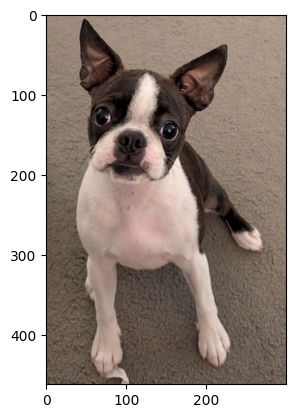

In [108]:
plt.imshow(img)

In [109]:
x = transform(img)
x = mx.array(x)

Add batch dimension:

In [110]:
x = mx.expand_dims(x, 0)

The first layer is a Conv3x3 with 32 channels. I'll create that, so we have the correct input shape for our MBConv1 layer.

In [111]:
nn.Conv2d?

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, tuple],
    stride: Union[int, tuple] = 1,
    padding: Union[int, tuple] = 0,
    dilation: Union[int, tuple] = 1,
    groups: int = 1,
    bias: bool = True,
)
Docstring:     
Applies a 2-dimensional convolution over the multi-channel input image.

The channels are expected to be last i.e. the input shape should be ``NHWC`` where:

* ``N`` is the batch dimension
* ``H`` is the input image height
* ``W`` is the input image width
* ``C`` is the number of input channels

Args:
    in_channels (int): The number of input channels.
    out_channels (int): The number of output channels.
    kernel_size (int or tuple): The size of the convolution filters.
    stride (int or tuple, optional): The size of the stride when
        applying the filter. Default: ``1``.
    padding (int or tuple, optional): How many positions to 0-pad
        the input with. Default: ``0``.
    dilation (int or tuple

These are RGB layers, so we'll need 3 input channels.

In [112]:
input_channels = 3

We know from the EfficientNet architecture that the first layer outputs 32 channels.

In [113]:
output_channels = 32

The kernel size is 3 (3x3 square convolution operation)

In [114]:
kernel_size = 3

And a stride of 2, which should half the size of the input image.

In [115]:
stride = 2

In [116]:
dilation = 1

In [117]:
padding = (kernel_size - 1) // 2 * dilation
padding

1

In [118]:
input_layer = nn.Conv2d(
    in_channels=input_channels,
    out_channels=output_channels,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding
)   

In [119]:
out1 = input_layer(x)

In [120]:
out1.shape

(1, 112, 112, 32)

Also has a Batch Norm and ReLU layer

In [121]:
bn1 = nn.BatchNorm(num_features=output_channels)
act1 = nn.ReLU()

In [122]:
out1 = act1(bn1(out1))

In [123]:
out1.shape

(1, 112, 112, 32)

In [124]:
out1

array([[[[0.806157, 0, 0, ..., 0.784009, 0, 0.545196],
         [0.369649, 0, 0, ..., 0.68847, 0, 1.75942],
         [0.713701, 0, 0, ..., 0.74158, 0, 1.26962],
         ...,
         [1.39186, 0, 0, ..., 1.47968, 0, 2.24572],
         [1.20704, 0, 0, ..., 1.31168, 0, 2.67725],
         [1.01396, 0, 0, ..., 1.52639, 0, 2.99694]],
        [[0.697691, 0, 0, ..., 0.792997, 0, 0.111414],
         [0.452443, 0, 0, ..., 0.417726, 0, 0.439502],
         [0.570814, 0.266545, 0, ..., 0.426739, 0, 0],
         ...,
         [0.733342, 1.43732, 0, ..., 0, 0.725128, 0],
         [0.610012, 0.289293, 0, ..., 0.774592, 0.371873, 0],
         [0.461869, 0.280822, 0, ..., 0.449082, 0.328861, 0.289809]],
        [[0.343948, 0, 0, ..., 0.384064, 0, 0],
         [0.399282, 0.48536, 0, ..., 0.303656, 0.418549, 0],
         [0.249546, 0, 0, ..., 0.439757, 0.35712, 0.255259],
         ...,
         [1.02768, 0, 0, ..., 0.983346, 0, 0.153198],
         [0.611463, 0, 0, ..., 0.798761, 0, 0.820197],
         [

# Mobile inverted bottleneck MBConv with Squeeze-and-Excitation optimization

An MBConv (Mobile Inverted Bottleneck Convolution) as described in the MobileNet paper has these stages:

1. Expand (1x1 conv) - increases channels by an expansion ratio - usually 6x)
2. Depthwise conv (3x3) - applies convolution separately per channel (groups = in_channels)
3. Squeeze & Excitation (SE) - channel-wise attention mechanism.
4. Project (1x1 conv) - reduces channels back to match output size.
5. Skip connection (if input/output shapes match).

### Expand

So we're going to increase channels by 6x.

In [125]:
expansion = 6
in_channels_mbconv = output_channels
out_channel_mbconv = 24
expanded_channels = expansion * in_channels_mbconv

expand_conv = nn.Conv2d(
    in_channels=in_channels_mbconv,
    out_channels=expanded_channels,
    kernel_size=1,
    stride=1,
    padding=0,
    bias=False
)
bn_expand = nn.BatchNorm(num_features=expanded_channels)
act_expand = nn.SiLU()

In [126]:
out2 = act_expand(bn_expand(expand_conv(out1)))

In [127]:
out2.shape

(1, 112, 112, 192)

### Depthwise Conv

Applies convolution separately per channel.

The intution here is that we're learning a filter per channel, which keeps computation cheap at the cost of not learning information across channels.

In [128]:
depthwise_conv = nn.Conv2d(
    in_channels=expanded_channels,
    out_channels=expanded_channels,
    kernel_size=3,
    stride=1,
    padding=1,
    # "When groups=in_channels, each input channel is convolved with its own set of filters."
    groups=expanded_channels,
    bias=False
)
bn_depth = nn.BatchNorm(num_features=expanded_channels)
act_depth = nn.SiLU()

In [129]:
out2_2 = act_depth(bn_depth(depthwise_conv(out2)))

In [130]:
out2_2.shape

(1, 112, 112, 192)

### Squeeze and Excitation

This small sub-block recalibrates channels using global pooling and two FC layers.

1. Global average pool across H,W per channel.
2. Reduce -> expand with small MLP
3. Mutiply (scale) back into the feature map.

Basically, we're simply calculating a weight per channel - think of it as attention for channels.

In [131]:
se_ratio = 0.25
squeezed_channels = int(expanded_channels * se_ratio)

In [132]:
se_reduce = nn.Conv2d(expanded_channels, squeezed_channels, kernel_size=1)
se_expand = nn.Conv2d(squeezed_channels, expanded_channels, kernel_size=1)

Take the average of each channel, to give us a single scalar per channel.

In [133]:
se = mx.mean(out2_2, axis=(1, 2), keepdims=True)   # global average pool
se.shape

(1, 1, 1, 192)

Then we reduce the channels to 25%

In [134]:
se_red = nn.SiLU()(se_reduce(se))
se_red.shape

(1, 1, 1, 48)

Then expand it back to the number channels (the idea is we throw out data for unimportant channels)

In [135]:
se = nn.Sigmoid()(se_expand(se_red))

In [136]:
se.shape; se

array([[[[0.511277, 0.494445, 0.493297, ..., 0.503363, 0.49867, 0.496543]]]], dtype=float32)

Now we multiply the output layer by those weights:

In [141]:
out2_3 = out2_2 * se

## Project

The last layer is a 1x1 that combines channel information.

In [142]:
project_conv = nn.Conv2d(
    in_channels=expanded_channels,
    out_channels=out_channel_mbconv,
    kernel_size=1,
    stride=1,
    padding=0,
    bias=False
)
bn_project = nn.BatchNorm(num_features=out_channel_mbconv)

In [143]:
bn_project(project_conv(out2_3)).shape

(1, 112, 112, 24)